<a href="https://colab.research.google.com/github/NadezhdaMalysheva/projects/blob/main/%D0%AD%D0%BA%D1%81%D0%BF%D0%B5%D1%80%D0%B8%D0%BC%D0%B5%D0%BD%D1%82%D1%8B_%D0%BF%D0%BE_%D0%BE%D1%82%D0%B1%D0%BE%D1%80%D1%83_%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Подгружаем необходимые библиотеки 

In [2]:
pip install pytorch-tabnet

In [3]:
import numpy as np
import pandas as pd

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls

%matplotlib inline

In [5]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import joblib
from tqdm.notebook import tqdm

from pytorch_tabnet.tab_model import TabNetClassifier

from hyperopt import hp
import numpy as np
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import lightgbm as lgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

from time import time
import joblib

In [6]:
import torch

#Загружаем данные, параметры

In [7]:
target = 'class'

add_columns = ['subClass', 'objID', 'z', 'zErr', 'ra', 'dec']

photo_columns = ['psfMag_u',	'psfMag_g',	'psfMag_r',	'psfMag_i',	'psfMag_z',
                 'cModelMag_u',	'cModelMag_g',	'cModelMag_r',	'cModelMag_i',	'cModelMag_z']

feature_columns = (
    photo_columns + add_columns + [target])

In [8]:
def data_preparation(X, y, test_size = 0.8):

    X1_train, X1_test, y1_train, y1_test = train_test_split(X[y==1], y[y==1], test_size=test_size, random_state = 43)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X[y==2], y[y==2], test_size=test_size, random_state = 43)
    X3_train, X3_test, y3_train, y3_test = train_test_split(X[y==3], y[y==3], test_size=test_size, random_state = 43)
    
    count = 10000
    count1 = 10000

    X_train, X_test = np.concatenate((X1_train[:count], X2_train[:count], X3_train[:count])), np.concatenate((X1_test[:count1], X2_test[:count1], X3_test[:count1]))
    y_train, y_test = np.concatenate((y1_train[:count], y2_train[:count], y3_train[:count])), np.concatenate((y1_test[:count1], y2_test[:count1], y3_test[:count1]))
    

    return [X_train, X_test, y_train, y_test, X1_train, X1_test, y1_train, y1_test, X2_train, X2_test, y2_train, y2_test, X3_train, X3_test, y3_train, y3_test]

In [9]:
def scor(y_test, y_pred):
  return accuracy_score(y_test, y_pred)

lgb_reg_params = {
    'learning_rate':    hp.uniform('learning_rate', 0.001, 0.1),
    'min_child_samples':hp.randint('min_child_samples', 50)+1,
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.9),
    'num_leaves' :      hp.randint('num_leaves', 100)+10,
    'min_child_weight': hp.uniform('min_child_weight', 0.001, 0.99),
    'n_estimators':     hp.randint('n_estimators', 1500)+100
}
lgb_fit_params = {
    'early_stopping_rounds': 20,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['score'] = lambda y, pred: -accuracy_score(y, pred)


rf_reg_params = {
    'min_samples_leaf': hp.randint('min_samples_leaf', 20)+1,
    'min_samples_split':hp.uniform('min_samples_split', 0.001, 0.1),
    #'max_features':     hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
    #'learning_rate':    hp.uniform('learning_rate', 0.001, 0.1),
    'n_estimators':     hp.randint('n_estimators', 800)+100
}
rf_fit_params = {
}
rf_para = dict()
rf_para['reg_params'] = rf_reg_params
rf_para['fit_params'] = rf_fit_params
rf_para['score'] = lambda y, pred: -accuracy_score(y, pred)

tabnet_reg_params = {
    'n_d' :              64,
    'n_a' :              64,
    'n_steps' :          hp.randint('n_steps', 10-3)+3,
    'gamma' :            hp.uniform('gamma', 1.0, 3.0),
    'lambda_sparse' :    hp.uniform('lambda_sparse', 0.0, 0.01),
    'momentum' :         0.3, 
    'clip_value' :       2.,
    'optimizer_params' : dict(lr=2e-2),
    'scheduler_params' : {"step_size":50, "gamma":0.9},
    'scheduler_fn' :     torch.optim.lr_scheduler.StepLR,
    'mask_type' :       'entmax'
}

tabnet_fit_params = {
    'max_epochs' : 100, 
    'patience' : 15,
    'batch_size' : 512,
    'virtual_batch_size' : 128,
    'num_workers' : 0,
    'weights' : 1,
    'drop_last' : False,
    #'from_unsupervised' : unsupervised_model
}
tabnet_para = dict()
tabnet_para['reg_params'] = tabnet_reg_params
tabnet_para['fit_params'] = tabnet_fit_params
tabnet_para['score'] = lambda y, pred: -accuracy_score(y, pred)

In [10]:
target = 'class'

add_columns = ['subClass', 'objID', 'z', 'zErr', 'ra', 'dec']

photo_columns = ['psfMag_u',	'psfMag_g',	'psfMag_r',	'psfMag_i',	'psfMag_z',
                 'cModelMag_u',	'cModelMag_g',	'cModelMag_r',	'cModelMag_i',	'cModelMag_z']

feature_columns = (
    photo_columns + add_columns + [target])

In [11]:
#X, y  = joblib.load('/content/drive/MyDrive/Научная работа/Спецсем/TabNetModel/X_y.pkl')
data_split = joblib.load('/content/drive/MyDrive/Научная работа/Спецсем/TabNetModel/data_split.pkl')

X_train, X_test = data_split[:2]
y_train, y_test = data_split[2:4]

train = np.concatenate((X_train, y_train.reshape((len(y_train), 1))), axis=1)
np.random.shuffle(train)
X_train, y_train = train[:,:-1], train[:,-1].astype('int')

count = 100000

X1_train, X1_test = data_split[4:6]
y1_train, y1_test = data_split[6:8]
X2_train, X2_test = data_split[8:10] 
y2_train, y2_test = data_split[10:12]
X3_train, X3_test = data_split[12:14]
y3_train, y3_test = data_split[14:16]

X_train_pred = np.concatenate((X1_test[2*count : 4*count], X2_test[2*count : 4*count], X3_test[2*count : 4*count])) ###############
X_val_pred   = np.concatenate((X1_test[count : 2*count], X2_test[count : 2*count], X3_test[count : 2*count]))
np.random.shuffle(X_train_pred)
np.random.shuffle(X_val_pred)

X_valid      = np.concatenate((X1_test[4*count : 5*count], X2_test[4*count : 5*count], X3_test[4*count : 5*count]))
y_valid      = np.concatenate((y1_test[4*count : 5*count], y2_test[4*count : 5*count], y3_test[4*count : 5*count]))

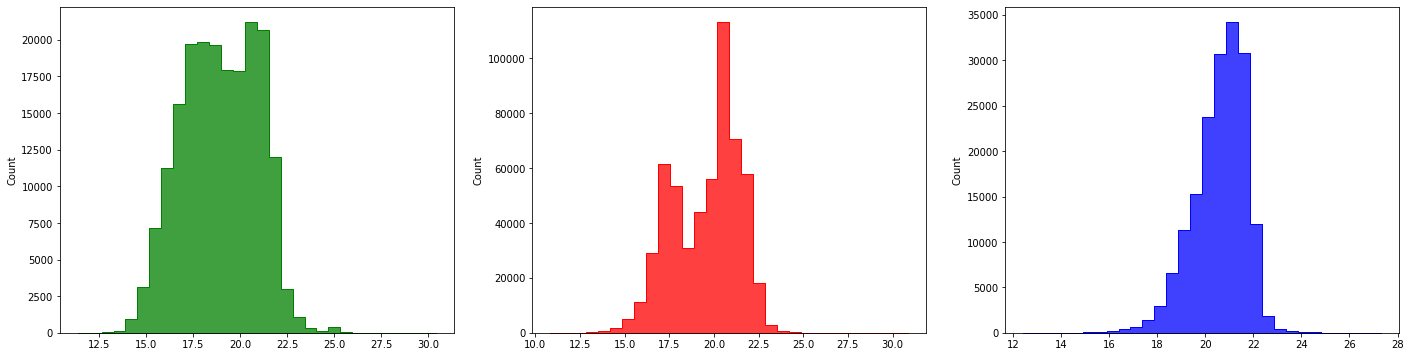

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (24, 6))
sns.histplot(X1_train[:, 7], ax = ax1, bins = 30, color = 'g', element="step")
sns.histplot(X2_train[:, 7], ax = ax2, bins = 30, color = 'r', element="step")
sns.histplot(X3_train[:, 7], ax = ax3, bins = 30, color = 'b', element="step")

Нормализация данных


In [13]:
robust = RobustScaler()

X_train_norm = robust.fit_transform(X_train)
X_test_norm = robust.transform(X_test)
X_valid_norm = robust.transform(X_valid)

In [14]:
import joblib
gb = joblib.load('/content/drive/MyDrive/Научная работа/Спецсем/TabNetModel/gb_model.pkl')
tn = joblib.load('/content/drive/MyDrive/Научная работа/Спецсем/TabNetModel/TabNet_model.pkl')
tn_pred = joblib.load('/content/drive/MyDrive/Научная работа/Спецсем/TabNetModel/TabNet_model_pred2.pkl')

#Проверка точности классификации

Будем использовать бутстрэп

In [ ]:
def bootstrap_accuracy(model, X_test, y_test):
  from sklearn.utils import resample
  from matplotlib import pyplot
  values = np.concatenate((X_test, y_test.reshape((len(y_test), 1))), axis=1)
  n_iterations = 500
  n_size = int(len(y_test) * 0.50)
  stats = list()
  for i in range(n_iterations):
    test = resample(values, n_samples=n_size)
    predictions = model.predict(test[:,:-1])
    score = accuracy_score(test[:,-1], predictions)
    stats.append(score)
  pyplot.hist(stats, range=(0.872, 0.9))
  pyplot.show()
  alpha = 0.8
  p = ((1.0-alpha)/2.0) * 100
  lower = max(0.0, np.percentile(stats, p))
  p = (alpha+((1.0-alpha)/2.0)) * 100
  upper = min(1.0, np.percentile(stats, p))
  print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))
  return stats

##Градиентный бустинг и обычный TabNet

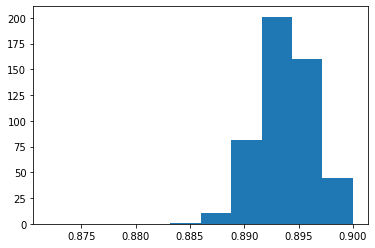

80.0 confidence interval 89.1% and 89.7%


In [ ]:
#gb = joblib.load('/content/drive/MyDrive/Научная работа/Спецсем/TabNetModel/gb_model.pkl')
statsGB = bootstrap_accuracy(gb, X_test_norm, y_test)

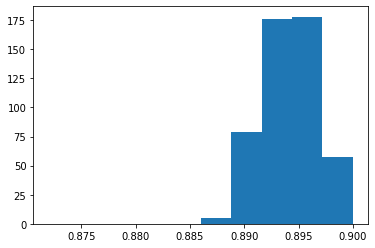

80.0 confidence interval 89.1% and 89.7%


In [ ]:
#tn = joblib.load('/content/drive/MyDrive/Научная работа/Спецсем/TabNetModel/TabNet_model.pkl')
statsTN = bootstrap_accuracy(tn, X_test, y_test)

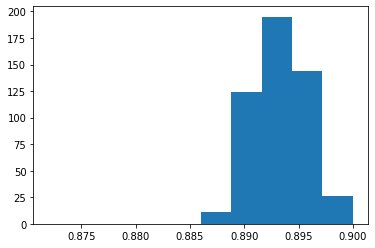

80.0 confidence interval 89.0% and 89.6%


In [ ]:
#tn = joblib.load('/content/drive/MyDrive/Научная работа/Спецсем/TabNetModel/TabNet_model.pkl')
statsTN_pred = bootstrap_accuracy(tn_pred, X_test, y_test)

In [ ]:
stat = pd.DataFrame()
stat['model'] = ['GB']*len(statsGB) + ['TN']*len(statsTN) + ['TN_pred']*len(statsTN_pred)
stat['acc'] = statsGB + statsTN + statsTN_pred

#Запуск на лучших 10 признаках

In [15]:
def bootstrap(X_test, y_test, X_valid, y_valid):
  from sklearn.utils import resample
  from matplotlib import pyplot
  values = np.concatenate((X_test, y_test.reshape((len(y_test), 1))), axis=1)
  n_iterations = 100
  n_size = int(len(y_test) * 0.50)
  stats = list()
  for i in range(n_iterations):
    print(i)
    train_ind = np.random.randint(0, len(values), n_size)
    test_ind = np.setdiff1d(range(len(values)), train_ind)
    train = values[train_ind]
    test = values[test_ind]
    # fit model
    model = lgb.LGBMClassifier()
    model.fit(train[:,:-1], train[:,-1], eval_set=[(train[:,:-1], train[:,-1]), (X_valid_norm, y_valid)], **lgb_fit_params)
    # evaluate model
    predictions = model.predict(test[:,:-1])
    test = resample(values, n_samples=n_size)
    predictions = model.predict(test[:,:-1])
    score = accuracy_score(test[:,-1], predictions)
    stats.append(score)
  pyplot.hist(stats, range=(0.872, 0.9))
  pyplot.show()
  alpha = 0.8
  p = ((1.0-alpha)/2.0) * 100
  lower = max(0.0, np.percentile(stats, p))
  p = (alpha+((1.0-alpha)/2.0)) * 100
  upper = min(1.0, np.percentile(stats, p))
  print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))
  return stats

In [ ]:
df = joblib.load('/content/drive/MyDrive/Научная работа/Спецсем/TabNetModel/df_agg.pkl')#pd.read_csv('/content/drive/MyDrive/Научная работа/Спецсем/TabNetModel/df_agg.csv')

In [ ]:
agr_feature = [x for x in df.columns if x not in feature_columns]

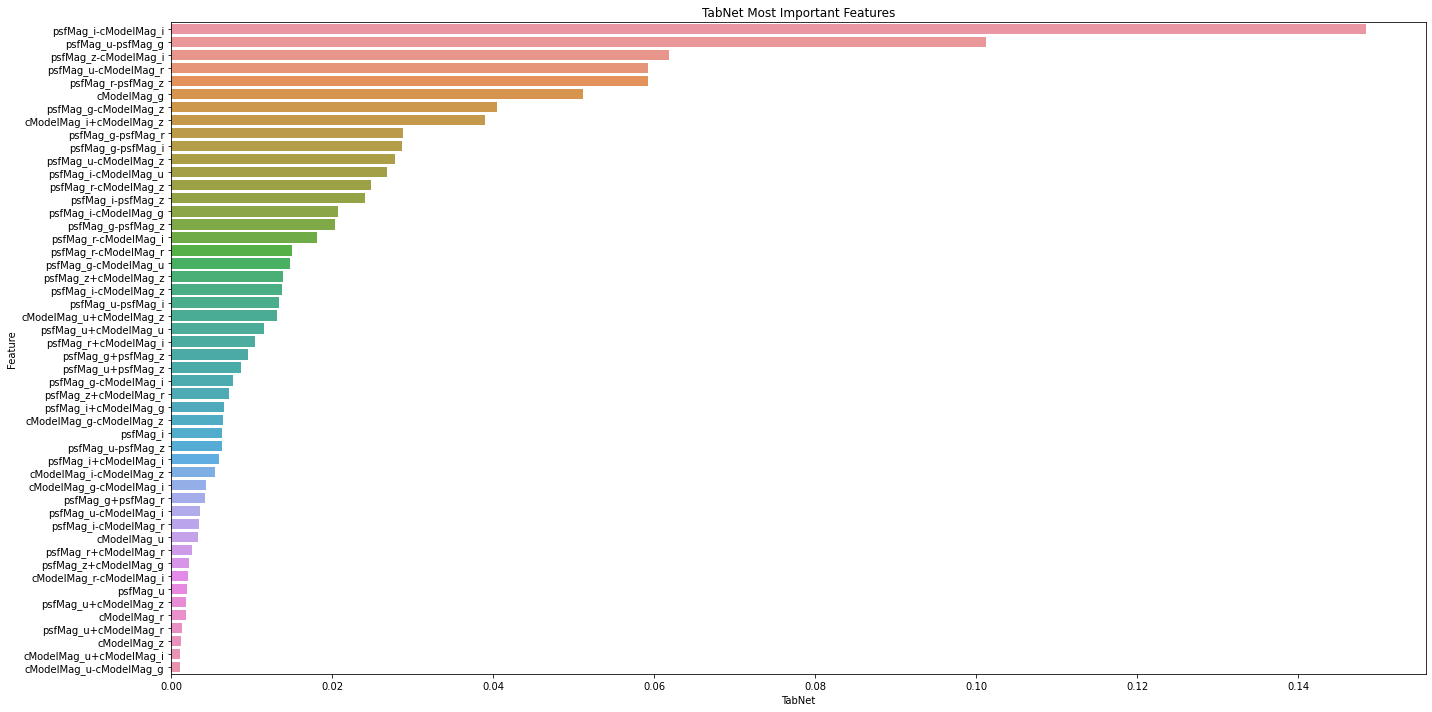

In [ ]:
feature_imp_tn=pd.DataFrame((zip(tn.feature_importances_,photo_columns+agr_feature)), columns=['TabNet','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="TabNet", y="Feature", data=feature_imp_tn.sort_values(by="TabNet", ascending=False).iloc[:50])
plt.title('TabNet Most Important Features')
plt.tight_layout()
plt.show()

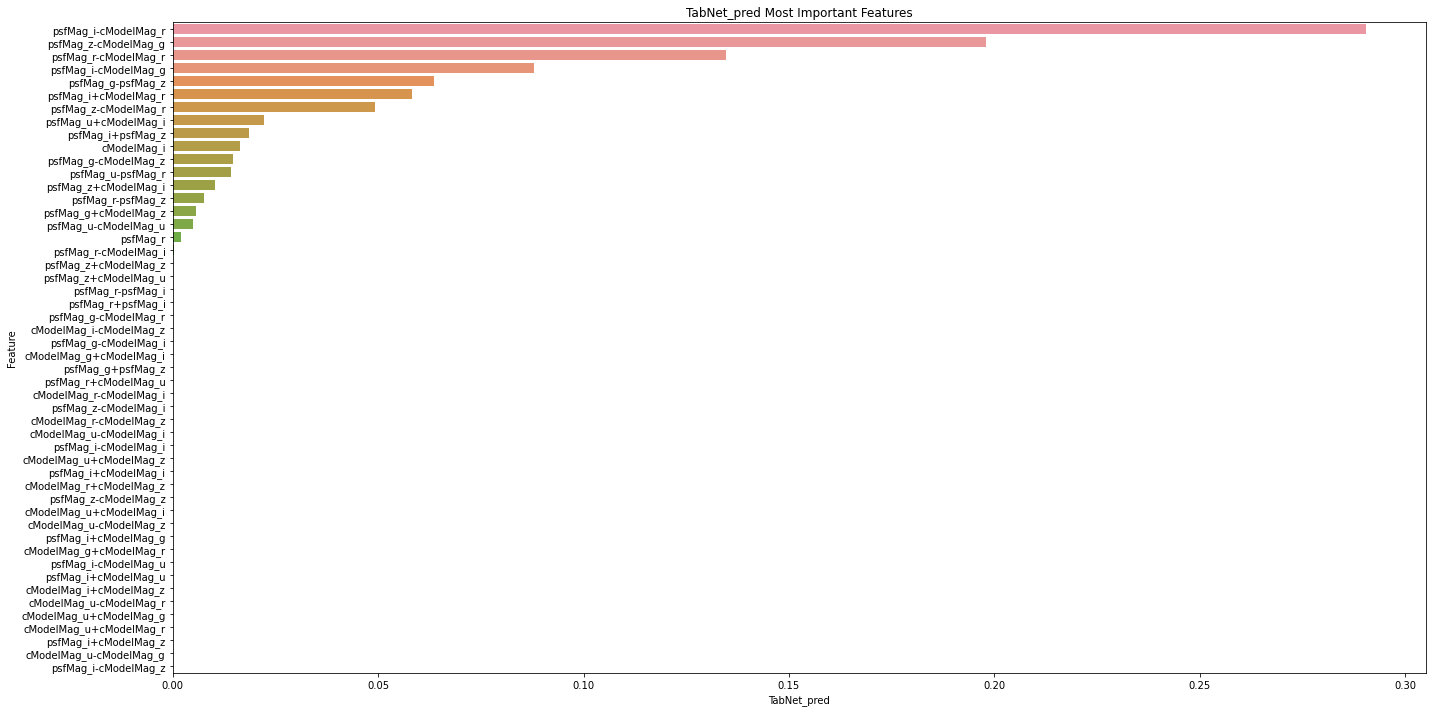

In [ ]:
feature_imp_tn_pred=pd.DataFrame((zip(tn_pred.feature_importances_,photo_columns+agr_feature)), columns=['TabNet_pred','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="TabNet_pred", y="Feature", data=feature_imp_tn_pred.sort_values(by="TabNet_pred", ascending=False).iloc[:50])
plt.title('TabNet_pred Most Important Features')
plt.tight_layout()
plt.show()

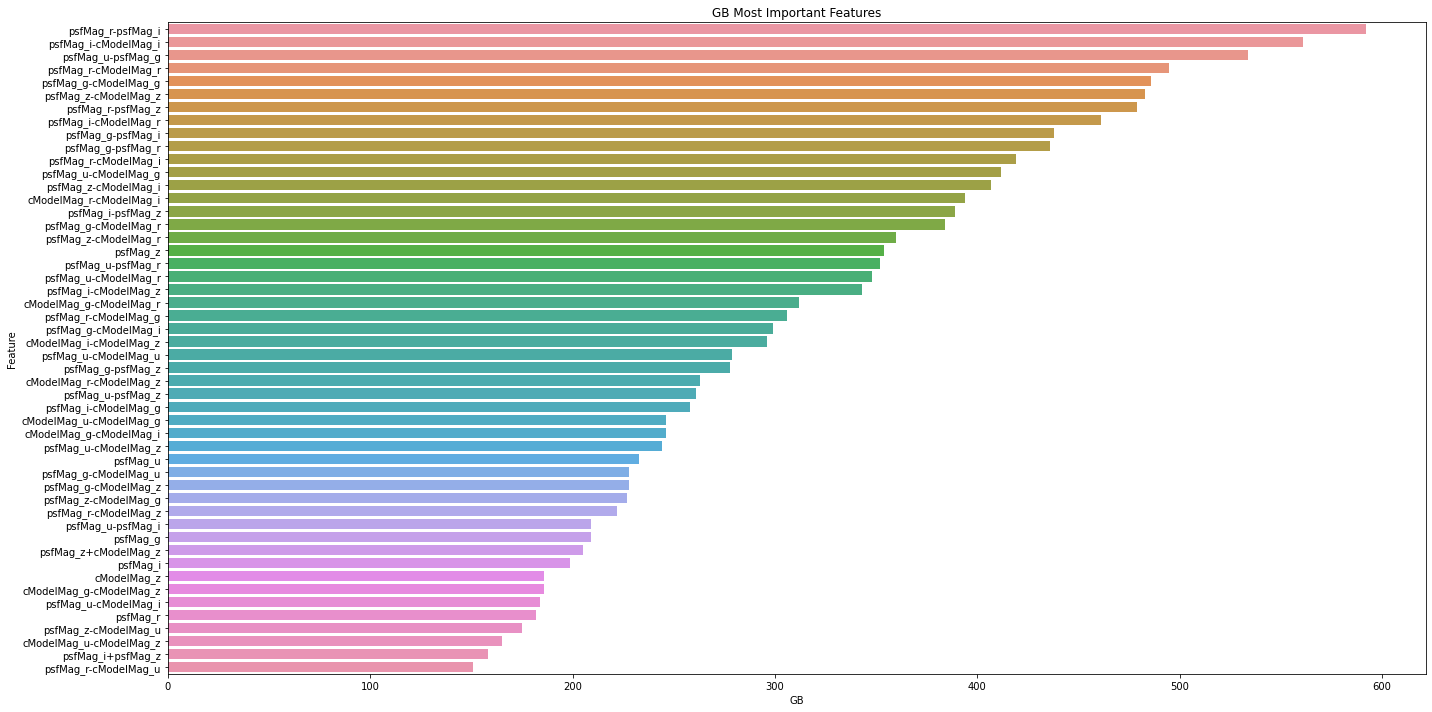

In [ ]:
feature_imp_gb=pd.DataFrame(sorted(zip(gb.feature_importances_, photo_columns+agr_feature)), columns=['GB','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="GB", y="Feature", data=feature_imp_gb.sort_values(by="GB", ascending=False).iloc[:50])
plt.title('GB Most Important Features')
plt.tight_layout()
plt.show()

In [ ]:
t = 10
tn_feature = feature_imp_tn.sort_values(by='TabNet', ascending=False).iloc[:t]['Feature'].values
tn_pred_feature = feature_imp_tn_pred.sort_values(by='TabNet_pred', ascending=False).iloc[:t]['Feature'].values
lgbm_feature = feature_imp_gb.sort_values(by='GB', ascending=False).iloc[:t]['Feature'].values 

In [ ]:
tn_feature, tn_pred_feature, lgbm_feature

(array(['psfMag_i-cModelMag_i', 'psfMag_u-psfMag_g',
        'psfMag_z-cModelMag_i'], dtype=object),
 array(['psfMag_i-cModelMag_r', 'psfMag_z-cModelMag_g',
        'psfMag_r-cModelMag_r'], dtype=object),
 array(['psfMag_r-psfMag_i', 'psfMag_i-cModelMag_i', 'psfMag_u-psfMag_g'],
       dtype=object))

In [ ]:
X_tn = df[tn_feature].values
X_tn_pred = df[tn_pred_feature].values
X_gb = df[lgbm_feature].values

In [ ]:
X_tn[0], X_tn_pred[0], X_gb[0]

(array([0.90205, 0.38229, 0.33859]),
 array([-0.03673, -0.50893,  0.67971]),
 array([0.71644, 0.90205, 0.38229]))

##На TabNet

In [ ]:
y = df[target].values

In [ ]:
data_split = data_preparation(X_tn, y)

X_train, X_test = data_split[:2]
y_train, y_test = data_split[2:4]

count = 10000

X1_train, X1_test = data_split[4:6]
y1_train, y1_test = data_split[6:8]
X2_train, X2_test = data_split[8:10] 
y2_train, y2_test = data_split[10:12]
X3_train, X3_test = data_split[12:14]
y3_train, y3_test = data_split[14:16]

X_train_pred = np.concatenate((X1_train[count : ], X2_train[count : ], X3_train[count : ])) ###############
X_val_pred   = np.concatenate((X1_test[count : 2*count], X2_test[count : 2*count], X3_test[count : 2*count]))
X_valid      = np.concatenate((X1_test[2*count : 3*count], X2_test[2*count : 3*count], X3_test[2*count : 3*count]))
y_valid      = np.concatenate((y1_test[2*count : 3*count], y2_test[2*count : 3*count], y3_test[2*count : 3*count]))

In [ ]:
X_train[0]

array([0.145  , 1.50838, 0.3105 ])

In [ ]:
robust = RobustScaler()

X_train_norm = robust.fit_transform(X_train)
X_test_norm = robust.transform(X_test)
X_valid_norm = robust.transform(X_valid)

In [ ]:
gb_check = lgb.LGBMClassifier()
gb_check.fit(X_train_norm, y_train, eval_set=[(X_train_norm, y_train), (X_valid_norm, y_valid)],  **lgb_fit_params)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
pred = gb_check.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb_check.predict(X_train_norm))
print('Training Score: ', gb_train_acc)
gb_test_acc =  accuracy_score(y_test, pred)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.83      0.84      0.84     10000
           2       0.89      0.93      0.91     10000
           3       0.83      0.77      0.80     10000

    accuracy                           0.85     30000
   macro avg       0.85      0.85      0.85     30000
weighted avg       0.85      0.85      0.85     30000

Confusion Matrix: 
 [[8415  393 1192]
 [ 255 9315  430]
 [1465  807 7728]]
Training Score:  0.8634
Testing Score:  0.8486


In [ ]:
#tn = joblib.load('/content/drive/MyDrive/Научная работа/Спецсем/TabNetModel/TabNet_model.pkl')
statsTN = bootstrap(X_test_norm, y_test, X_valid_norm, y_valid)

##На предобученном TabNet

In [ ]:
data_split = data_preparation(X_tn_pred, y)

X_train, X_test = data_split[:2]
y_train, y_test = data_split[2:4]

count = 10000

X1_train, X1_test = data_split[4:6]
y1_train, y1_test = data_split[6:8]
X2_train, X2_test = data_split[8:10] 
y2_train, y2_test = data_split[10:12]
X3_train, X3_test = data_split[12:14]
y3_train, y3_test = data_split[14:16]

X_train_pred = np.concatenate((X1_train[count : ], X2_train[count : ], X3_train[count : ])) ###############
X_val_pred   = np.concatenate((X1_test[count : 2*count], X2_test[count : 2*count], X3_test[count : 2*count]))
X_valid      = np.concatenate((X1_test[2*count : 3*count], X2_test[2*count : 3*count], X3_test[2*count : 3*count]))
y_valid      = np.concatenate((y1_test[2*count : 3*count], y2_test[2*count : 3*count], y3_test[2*count : 3*count]))

In [ ]:
X_train[0]

array([0.33752, 0.74472, 0.10797])

In [ ]:
robust = RobustScaler()

X_train_norm = robust.fit_transform(X_train)
X_test_norm = robust.transform(X_test)
X_valid_norm = robust.transform(X_valid)

In [ ]:
gb_check = lgb.LGBMClassifier()
gb_check.fit(X_train_norm, y_train, eval_set=[(X_train_norm, y_train), (X_valid_norm, y_valid)],  **lgb_fit_params)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
pred = gb_check.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb_check.predict(X_train_norm))
print('Training Score: ', gb_train_acc)
gb_test_acc =  accuracy_score(y_test, pred)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.81      0.74      0.77     10000
           2       0.88      0.94      0.91     10000
           3       0.76      0.77      0.76     10000

    accuracy                           0.82     30000
   macro avg       0.82      0.82      0.82     30000
weighted avg       0.82      0.82      0.82     30000

Confusion Matrix: 
 [[7363  527 2110]
 [ 196 9438  366]
 [1546  735 7719]]
Training Score:  0.8299666666666666
Testing Score:  0.8173333333333334


In [ ]:
#tn = joblib.load('/content/drive/MyDrive/Научная работа/Спецсем/TabNetModel/TabNet_model.pkl')
statsTN_pred = bootstrap(X_test_norm, y_test, X_valid_norm, y_valid)

##На градиентном бустинге

In [ ]:
data_split = data_preparation(X_gb, y)

X_train, X_test = data_split[:2]
y_train, y_test = data_split[2:4]

count = 10000

X1_train, X1_test = data_split[4:6]
y1_train, y1_test = data_split[6:8]
X2_train, X2_test = data_split[8:10] 
y2_train, y2_test = data_split[10:12]
X3_train, X3_test = data_split[12:14]
y3_train, y3_test = data_split[14:16]

X_train_pred = np.concatenate((X1_train[count : ], X2_train[count : ], X3_train[count : ])) ###############
X_val_pred   = np.concatenate((X1_test[count : 2*count], X2_test[count : 2*count], X3_test[count : 2*count]))
X_valid      = np.concatenate((X1_test[2*count : 3*count], X2_test[2*count : 3*count], X3_test[2*count : 3*count]))
y_valid      = np.concatenate((y1_test[2*count : 3*count], y2_test[2*count : 3*count], y3_test[2*count : 3*count]))

In [ ]:
robust = RobustScaler()

X_train_norm = robust.fit_transform(X_train)
X_test_norm = robust.transform(X_test)
X_valid_norm = robust.transform(X_valid)

In [ ]:
gb_check = lgb.LGBMClassifier()
gb_check.fit(X_train_norm, y_train, eval_set=[(X_train_norm, y_train), (X_valid_norm, y_valid)],  **lgb_fit_params)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
pred = gb_check.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb_check.predict(X_train_norm))
print('Training Score: ', gb_train_acc)
gb_test_acc =  accuracy_score(y_test, pred)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.84      0.85      0.85     10000
           2       0.89      0.94      0.92     10000
           3       0.85      0.80      0.82     10000

    accuracy                           0.86     30000
   macro avg       0.86      0.86      0.86     30000
weighted avg       0.86      0.86      0.86     30000

Confusion Matrix: 
 [[8520  428 1052]
 [ 238 9397  365]
 [1346  696 7958]]
Training Score:  0.8761666666666666
Testing Score:  0.8625


In [ ]:
#gb = joblib.load('/content/drive/MyDrive/Научная работа/Спецсем/TabNetModel/gb_model.pkl')
statsGB = bootstrap(X_test_norm, y_test, X_valid_norm, y_valid)

##Сравнение

In [ ]:
stat = pd.DataFrame()
stat['model'] = ['GB']*len(statsGB) + ['TN']*len(statsTN) + ['TN_pred']*len(statsTN_pred)
stat['acc'] = statsGB + statsTN + statsTN_pred

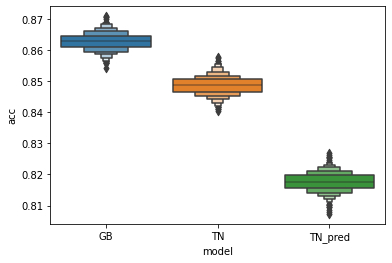

In [ ]:
sns.boxenplot(x='model', y='acc', data=stat)

#Запуск на лучших 3 признаках

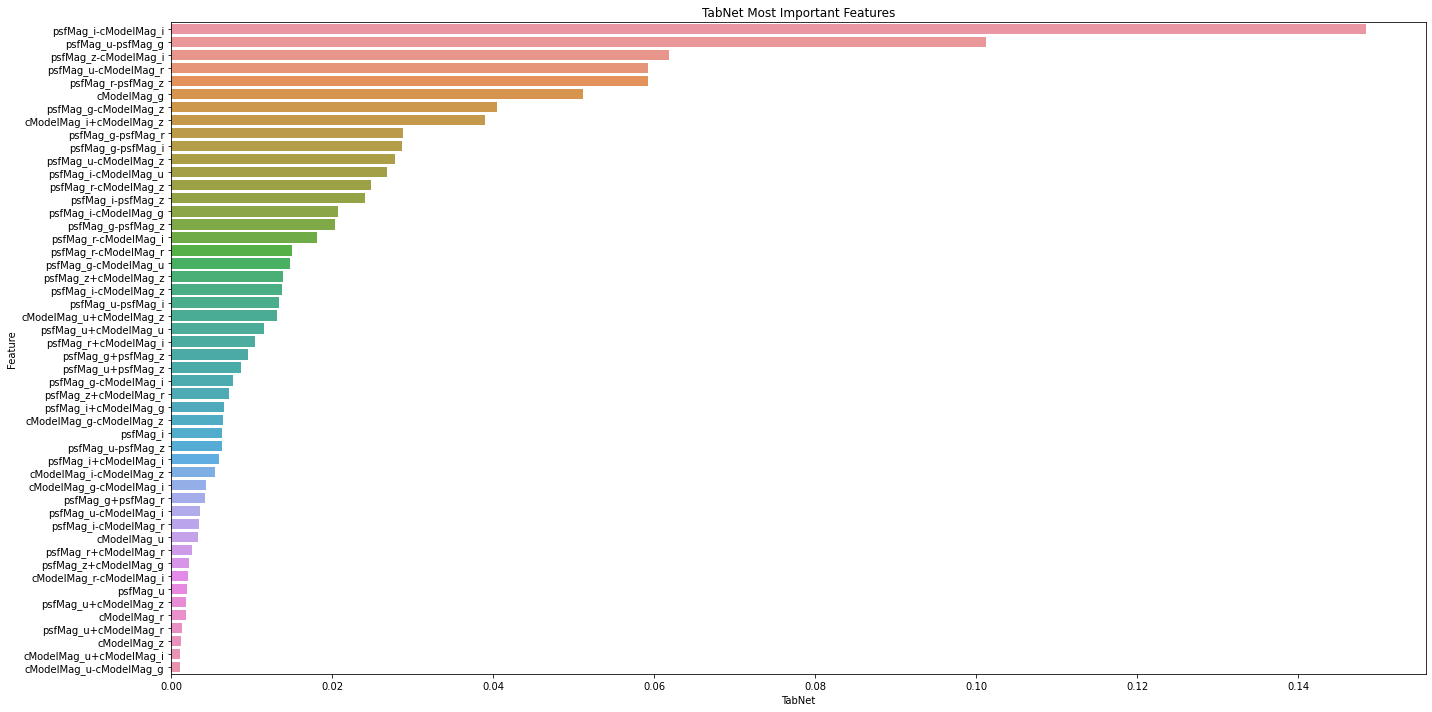

In [ ]:
feature_imp_tn=pd.DataFrame((zip(tn.feature_importances_,photo_columns+agr_feature)), columns=['TabNet','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="TabNet", y="Feature", data=feature_imp_tn.sort_values(by="TabNet", ascending=False).iloc[:50])
plt.title('TabNet Most Important Features')
plt.tight_layout()
plt.show()

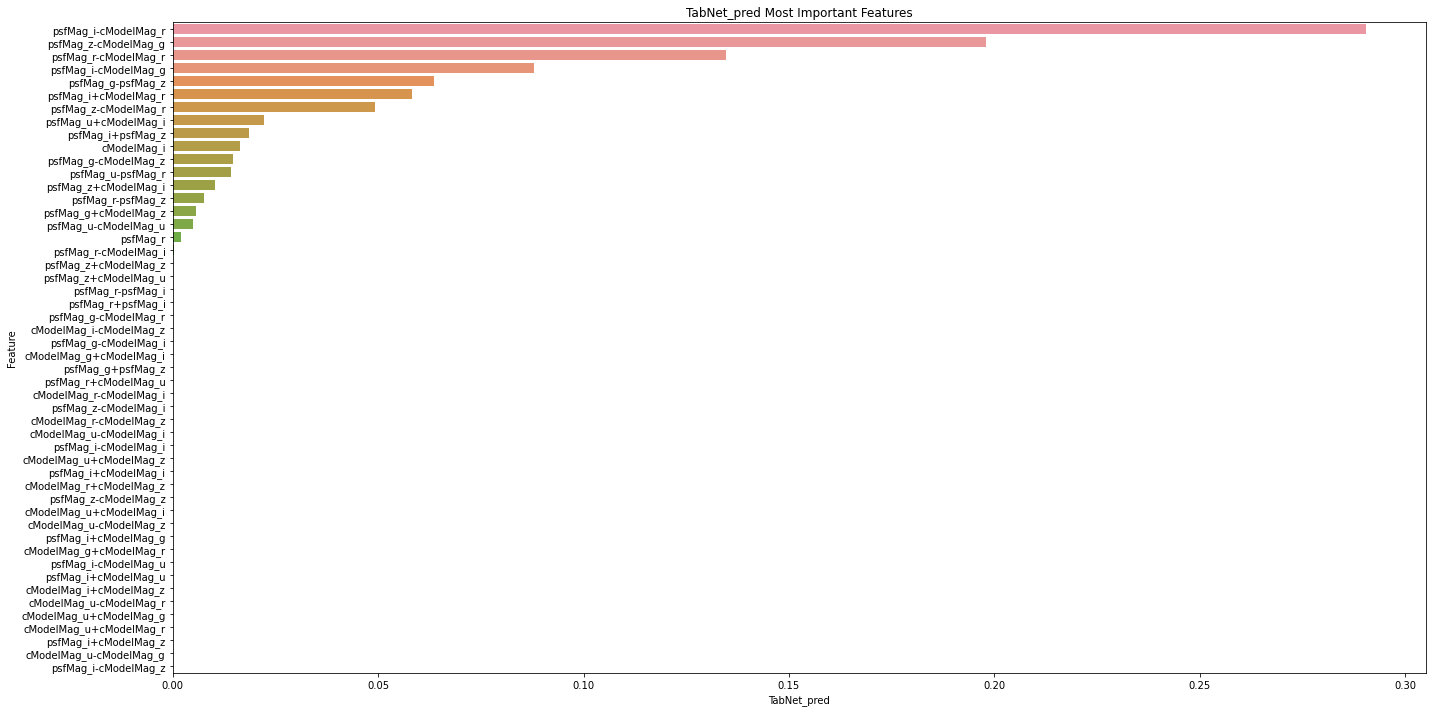

In [ ]:
feature_imp_tn_pred=pd.DataFrame((zip(tn_pred.feature_importances_,photo_columns+agr_feature)), columns=['TabNet_pred','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="TabNet_pred", y="Feature", data=feature_imp_tn_pred.sort_values(by="TabNet_pred", ascending=False).iloc[:50])
plt.title('TabNet_pred Most Important Features')
plt.tight_layout()
plt.show()

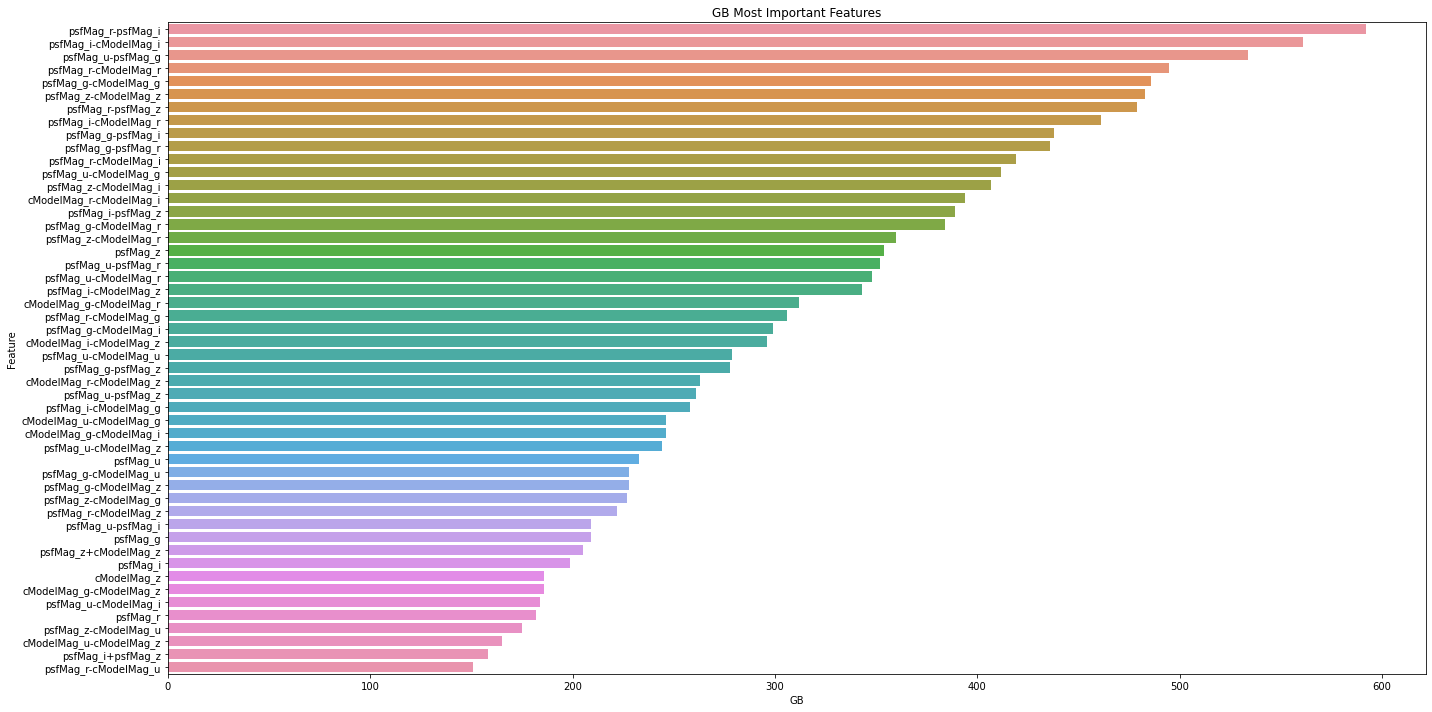

In [ ]:
feature_imp_gb=pd.DataFrame(sorted(zip(gb.feature_importances_, photo_columns+agr_feature)), columns=['GB','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="GB", y="Feature", data=feature_imp_gb.sort_values(by="GB", ascending=False).iloc[:50])
plt.title('GB Most Important Features')
plt.tight_layout()
plt.show()

In [ ]:
t = 3
tn_feature = feature_imp_tn.sort_values(by='TabNet', ascending=False).iloc[:t]['Feature'].values
tn_pred_feature = feature_imp_tn_pred.sort_values(by='TabNet_pred', ascending=False).iloc[:t]['Feature'].values
lgbm_feature = feature_imp_gb.sort_values(by='GB', ascending=False).iloc[:t]['Feature'].values 

In [ ]:
tn_feature, tn_pred_feature, lgbm_feature

(array(['psfMag_i-cModelMag_i', 'psfMag_u-psfMag_g',
        'psfMag_z-cModelMag_i'], dtype=object),
 array(['psfMag_i-cModelMag_r', 'psfMag_z-cModelMag_g',
        'psfMag_r-cModelMag_r'], dtype=object),
 array(['psfMag_r-psfMag_i', 'psfMag_i-cModelMag_i', 'psfMag_u-psfMag_g'],
       dtype=object))

In [ ]:
X_tn = df[tn_feature].values
X_tn_pred = df[tn_pred_feature].values
X_gb = df[lgbm_feature].values

In [ ]:
X_tn[0], X_tn_pred[0], X_gb[0]

(array([0.90205, 0.38229, 0.33859]),
 array([-0.03673, -0.50893,  0.67971]),
 array([0.71644, 0.90205, 0.38229]))

##На TabNet

In [ ]:
y = df[target].values

In [ ]:
data_split = data_preparation(X_tn, y)

X_train, X_test = data_split[:2]
y_train, y_test = data_split[2:4]

count = 10000

X1_train, X1_test = data_split[4:6]
y1_train, y1_test = data_split[6:8]
X2_train, X2_test = data_split[8:10] 
y2_train, y2_test = data_split[10:12]
X3_train, X3_test = data_split[12:14]
y3_train, y3_test = data_split[14:16]

X_train_pred = np.concatenate((X1_train[count : ], X2_train[count : ], X3_train[count : ])) ###############
X_val_pred   = np.concatenate((X1_test[count : 2*count], X2_test[count : 2*count], X3_test[count : 2*count]))
X_valid      = np.concatenate((X1_test[2*count : 3*count], X2_test[2*count : 3*count], X3_test[2*count : 3*count]))
y_valid      = np.concatenate((y1_test[2*count : 3*count], y2_test[2*count : 3*count], y3_test[2*count : 3*count]))

In [ ]:
X_train[0]

array([0.145  , 1.50838, 0.3105 ])

In [ ]:
robust = RobustScaler()

X_train_norm = robust.fit_transform(X_train)
X_test_norm = robust.transform(X_test)
X_valid_norm = robust.transform(X_valid)

In [ ]:
gb_check = lgb.LGBMClassifier()
gb_check.fit(X_train_norm, y_train, eval_set=[(X_train_norm, y_train), (X_valid_norm, y_valid)],  **lgb_fit_params)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
pred = gb_check.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb_check.predict(X_train_norm))
print('Training Score: ', gb_train_acc)
gb_test_acc =  accuracy_score(y_test, pred)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.83      0.84      0.84     10000
           2       0.89      0.93      0.91     10000
           3       0.83      0.77      0.80     10000

    accuracy                           0.85     30000
   macro avg       0.85      0.85      0.85     30000
weighted avg       0.85      0.85      0.85     30000

Confusion Matrix: 
 [[8415  393 1192]
 [ 255 9315  430]
 [1465  807 7728]]
Training Score:  0.8634
Testing Score:  0.8486


In [ ]:
#tn = joblib.load('/content/drive/MyDrive/Научная работа/Спецсем/TabNetModel/TabNet_model.pkl')
statsTN = bootstrap(X_test_norm, y_test, X_valid_norm, y_valid)

##На градиентном бустинге

In [ ]:
data_split = data_preparation(X_gb, y)

X_train, X_test = data_split[:2]
y_train, y_test = data_split[2:4]

count = 10000

X1_train, X1_test = data_split[4:6]
y1_train, y1_test = data_split[6:8]
X2_train, X2_test = data_split[8:10] 
y2_train, y2_test = data_split[10:12]
X3_train, X3_test = data_split[12:14]
y3_train, y3_test = data_split[14:16]

X_train_pred = np.concatenate((X1_train[count : ], X2_train[count : ], X3_train[count : ])) ###############
X_val_pred   = np.concatenate((X1_test[count : 2*count], X2_test[count : 2*count], X3_test[count : 2*count]))
X_valid      = np.concatenate((X1_test[2*count : 3*count], X2_test[2*count : 3*count], X3_test[2*count : 3*count]))
y_valid      = np.concatenate((y1_test[2*count : 3*count], y2_test[2*count : 3*count], y3_test[2*count : 3*count]))

In [ ]:
robust = RobustScaler()

X_train_norm = robust.fit_transform(X_train)
X_test_norm = robust.transform(X_test)
X_valid_norm = robust.transform(X_valid)

In [ ]:
gb_check = lgb.LGBMClassifier()
gb_check.fit(X_train_norm, y_train, eval_set=[(X_train_norm, y_train), (X_valid_norm, y_valid)],  **lgb_fit_params)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
pred = gb_check.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb_check.predict(X_train_norm))
print('Training Score: ', gb_train_acc)
gb_test_acc =  accuracy_score(y_test, pred)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.84      0.85      0.85     10000
           2       0.89      0.94      0.92     10000
           3       0.85      0.80      0.82     10000

    accuracy                           0.86     30000
   macro avg       0.86      0.86      0.86     30000
weighted avg       0.86      0.86      0.86     30000

Confusion Matrix: 
 [[8520  428 1052]
 [ 238 9397  365]
 [1346  696 7958]]
Training Score:  0.8761666666666666
Testing Score:  0.8625


In [ ]:
#gb = joblib.load('/content/drive/MyDrive/Научная работа/Спецсем/TabNetModel/gb_model.pkl')
statsGB = bootstrap(X_test_norm, y_test, X_valid_norm, y_valid)

##Сравнение

In [ ]:
stat = pd.DataFrame()
stat['model'] = ['GB']*len(statsGB) + ['TN']*len(statsTN) 
stat['acc'] = statsGB + statsTN 

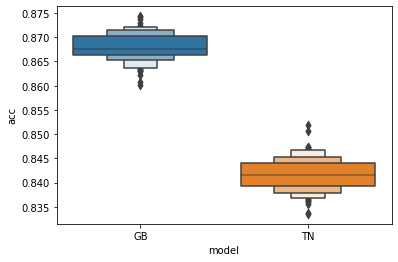

In [ ]:
sns.boxenplot(x='model', y='acc', data=stat)

#Метрики точности в зависимости от признаков

In [ ]:
classifier = tn

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
Y = label_binarize(y_test, classes=[1, 2, 3])
n_classes = Y.shape[1]

y_score = classifier.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(Y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

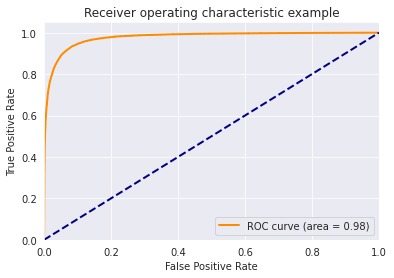

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

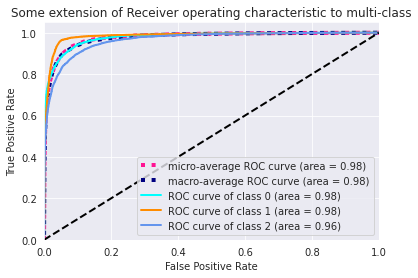

In [ ]:
from itertools import cycle
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
def prec_rec(ml, X1_test, y1_test, X2_test, y2_test, X3_test, y3_test, true_rt=False, rt = None):
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_curve, auc
    
    X_test_not_scaling = X1_test[X1_test[:,7].argsort()]
    X_test = X1_test[X1_test[:,7].argsort()]#################
    if true_rt:
      X_test = rt.transform(X_test)
    y_test = y1_test[X1_test[:,7].argsort()]
    
    #shift = 1000
    #n = len(y_test)//shift
    n = 14
    shift = len(y_test)//n

    plt.figure(figsize=(10, 10))
    lines = []
    labels = []
    AUC = []
    r = []
    clr = ['red', 'orangered', 'chocolate', 'darkorange', 'orange', 'gold', 'yellow', 'greenyellow', 'lime', 'springgreen', 'aquamarine', 'aqua', 'skyblue', 'lightskyblue']
   
    #y_pred_all = ml.predict(X_test)
    y_pred_all_proba = ml.predict_proba(X_test)
    j = 0

    for i in range(0, n):
            r1 = X_test_not_scaling[i*shift][7]
            r2 = X_test_not_scaling[(i+1) * shift - 1][7]

            X2 = X2_test[(X2_test[:, 7] >= r1) & (X2_test[:, 7] <= r2)]
            y2 = y2_test[(X2_test[:, 7] >= r1) & (X2_test[:, 7] <= r2)]
            ind2 = np.random.choice(len(y2), size=min(shift, len(y2)), replace=False)

            X3 = X3_test[(X3_test[:, 7] >= r1) & (X3_test[:, 7] <= r2)]
            y3 = y3_test[(X3_test[:, 7] >= r1) & (X3_test[:, 7] <= r2)]
            ind3 = np.random.choice(len(y3), size=min(shift, len(y3)), replace=False)

            X = np.concatenate((X2[ind2], X3[ind3]))
            if true_rt:
              X = rt.transform(X)
            y = np.concatenate((y2[ind2], y3[ind3]))

            print(i, shift, len(y2), len(y3))

            yt = np.concatenate((y_test[i*shift : (i+1) * shift], y))
            yt = label_binarize(yt, classes=[1, 2, 3])
            yp = np.concatenate((y_pred_all_proba[i*shift : (i+1) * shift], ml.predict_proba(X)))###################

            f, t, thresholds = roc_curve(yt.ravel(), yp.ravel())
            l, = plt.plot(f, t, color=clr[j], lw=2)
            j+=1
            lines.append(l)
            r1 = X_test_not_scaling[i*shift : (i+1) * shift][:,7].mean()
            labels.append('r = ' + str(r1))
            r.append(r1)
            AUC.append(auc(f, t))
            
    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC multi-class')
    plt.legend(lines, labels, loc=(0, -0.75), prop=dict(size=14))
    plt.show()

    plt.figure()
    plt.title('AUC')
    plt.plot(r, AUC, 'b')
    plt.plot([0,1],[0,1],'r--')
    plt.ylim([0.75, 1])
    plt.xlim([22,16])
    plt.ylabel('AUC')
    plt.xlabel('R')
    plt.show()

   # return fpr, tpr, r_mean, AUC, r

0 54877 59649 735
1 54877 93717 1212
2 54877 140952 2096
3 54877 207609 3646
4 54877 129073 6121
5 54877 75913 14118
6 54877 90398 25953
7 54877 120080 43226
8 54877 138398 65676
9 54877 236150 91092
10 54877 290282 101774
11 54877 202664 107558
12 54877 171220 123767
13 54877 275127 105167


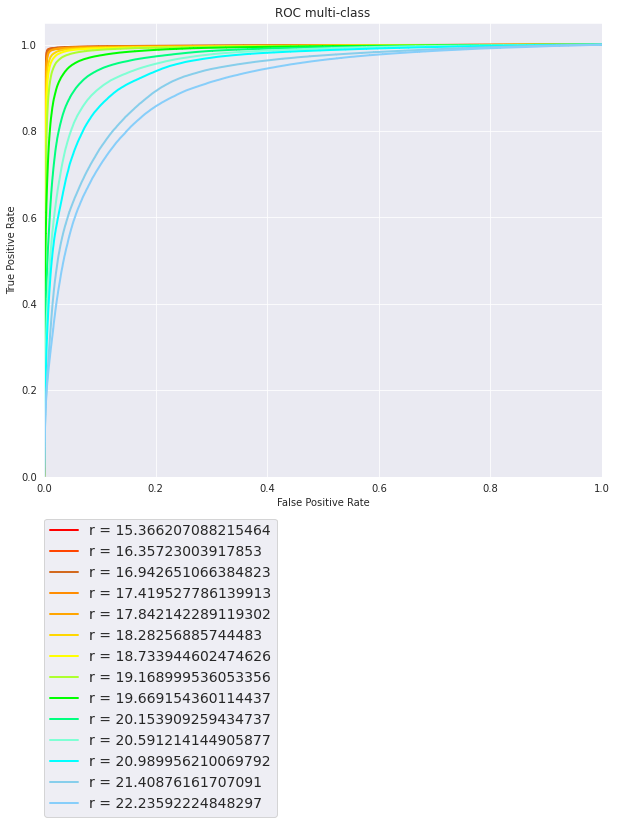

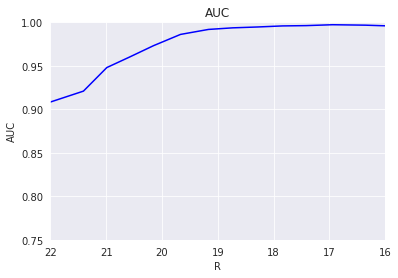

In [ ]:
prec_rec(tn, X1_test, y1_test, X2_test, y2_test, X3_test, y3_test)

0 54877 59649 735
1 54877 93717 1212
2 54877 140952 2096
3 54877 207609 3646
4 54877 129073 6121
5 54877 75913 14118
6 54877 90398 25953
7 54877 120080 43226
8 54877 138398 65676
9 54877 236150 91092
10 54877 290282 101774
11 54877 202664 107558
12 54877 171220 123767
13 54877 275127 105167


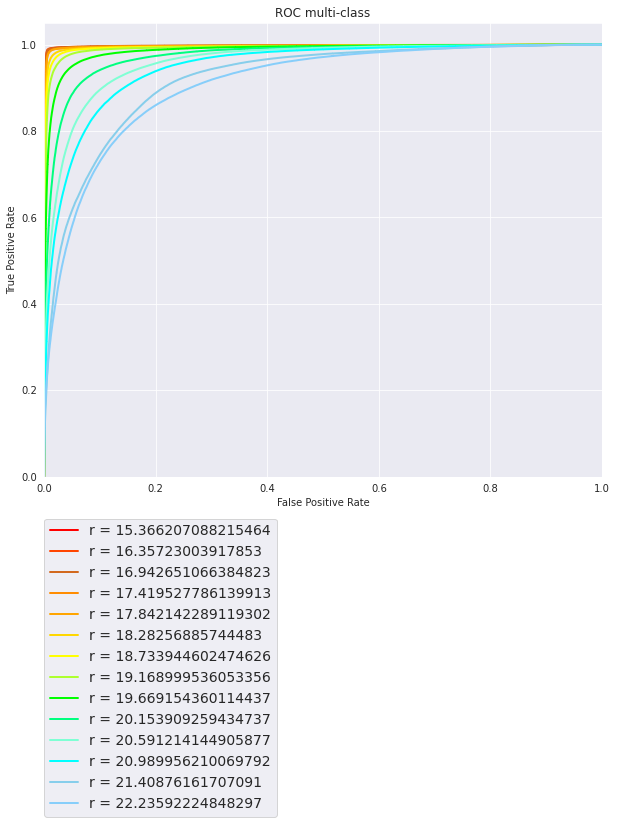

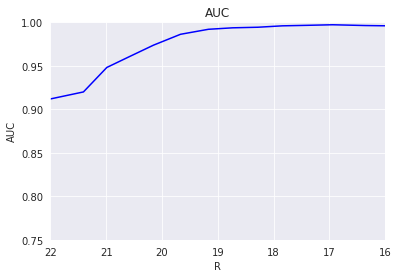

In [ ]:
prec_rec(gb, X1_test, y1_test, X2_test, y2_test, X3_test, y3_test, True, robust)